# Part 3

# Setup

In [8]:
using Plots, LaTeXStrings
using JuMP, HiGHS

include("src/utils.jl")
include("src/extended_form.jl")
include("src/scenario_tree.jl")
include("src/sddp.jl")
include("src/perf.jl")

compute_evpi (generic function with 1 method)

In [2]:
DATA_DIR = "data/"

"data/"

In [3]:
prices = vec(read_file(DATA_DIR * "belpex_price.txt"))
states = vec(read_file(DATA_DIR * "markov_support_4.txt"))
P_prob = read_file(DATA_DIR * "markov_weights_4.txt")

4×4 Matrix{Float64}:
 0.394106    0.524075   0.0807228  0.00109546
 0.107876    0.564185   0.311323   0.016616
 0.016616    0.311323   0.564185   0.107876
 0.00109546  0.0807228  0.524075   0.394106

# Questions

Now, consider the full multistge stochastic model

#### 1. How many nodes are there in the full scenario tree ?

For N possible different states and T time steps, we have only one node at $t=1$ (assumed to be in state 1). At $t=2$, we then have $N$ possible outcomes (i.e children in the tree), whose transition probabilities are depending on the Markov chain, so at $t=2$, we have $N$ nodes. At $t=3$, all the possible nodes at $t=2$ also have $N$ children each, so $N^2$ nodes in total. We continue like this until $t=T$, where there are $N^{T-1}$ children nodes. In total, there are $\sum_{t=0}^{T-1} N^t$ nodes, which is equal to $\frac{N^T-1}{N-1}$ nodes. Setting $T=24$ and $N=4$, we then obtain $\frac{4^{24}-1}{3}$ nodes which is $\approx 9.38 \times 10^{13}$ nodes.

#### 2. Implement both the extended formulation of the multistage stochastic program and the scenario tree formulation for $H < T$. Solve both formulations for $H=1,2,\dots$ until you reach the memory limit of your computer. What is the maximum $\bar{H}$ that your computer can handle ?

The maximal H that my computer can handle is 11.

In [6]:
N = 4
H = 4

4

In [7]:
scenarios = generate_scenarios(H, N)
num_scenarios = length(scenarios)

λ_paths = Vector{Vector{Float64}}(undef, num_scenarios)
ζ_paths = Vector{Vector{Float64}}(undef, num_scenarios)
probs = zeros(num_scenarios)
for (i, s) in enumerate(scenarios)
    λ_paths[i], ζ_paths[i], probs[i] = compute_price_path(H,s,prices,states, P_prob)
end

m_ext = extended_multistage(λ_paths, ζ_paths, probs, H, num_scenarios)
optimize!(m_ext)

println("Objective value: ", objective_value(m_ext))

Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Objective value: 12492.610771114521


In [8]:
tree = build_tree(H, N, P_prob)
m_tree = scenario_tree(states, prices, tree)

optimize!(m_tree)

println("Objective value: ", objective_value(m_tree))

Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Objective value: 12492.61077111453


### 3. Plot the evolution of the number of variables and constraints for both formulations as H increases from $1$ to $\bar{H}$ 

In [ ]:
H_vals = 1:11
vars_ext = Int[]
cons_ext = Int[]
vars_tree = Int[]
cons_tree = Int[]

N = 4

for H in H_vals
    # extended
    scenarios = generate_scenarios(H, N)
    println(H)
    num_scenarios = length(scenarios)
    λ_paths = Vector{Vector{Float64}}(undef, num_scenarios)
    probs = zeros(num_scenarios)
    for (i, s) in enumerate(scenarios)
        λ_paths[i], probs[i] = compute_price_path(H, s, prices, states, P_prob)
    end

    model_ext = extended_multistage(λ_paths, H, num_scenarios)
    push!(vars_ext, num_variables(model_ext))
    push!(cons_ext, num_constraints(model_ext; count_variable_in_set_constraints = false))

    # tree
    tree = build_tree(H, N, P_prob)
    model_tree = scenario_tree(states, prices, tree)
    push!(vars_tree, num_variables(model_tree))
    push!(cons_tree, num_constraints(model_tree; count_variable_in_set_constraints = false))
end

cons_ext_clean = [c == 0 ? NaN : c for c in cons_ext]
cons_tree_clean = [c == 0 ? NaN : c for c in cons_tree]

# Plot variables
plt_vars = plot(
    H_vals[1:length(vars_ext)], vars_ext,
    label = "Extended",
    lw = 2, marker = :circle,
    xlabel = "H", ylabel = "Number of Variables",
    title = "Variables vs H",
    yscale =:log10
)
plot!(
    H_vals[1:length(vars_tree)], vars_tree,
    label = "Scenario Tree",
    lw = 2, marker = :square
)
savefig(plt_vars, "data/variables_vs_H.pdf")


# Plot constraints
plt_cons = plot(
    H_vals[1:length(cons_ext)], cons_ext_clean,
    label = "Extended",
    lw = 2, marker = :circle,
    xlabel = "H", ylabel = "Number of Constraints",
    title = "Constraints vs H",
    yscale =:log10
)
plot!(
    H_vals[1:length(cons_tree_clean)], cons_tree_clean,
    label = "Scenario Tree",
    lw = 2, marker = :square
)
savefig(plt_cons, "data/constraints_vs_H.pdf")

----

### 4. Solve the full stochastic model using SDDP for 𝑁 ∈ {4,8,16,32} and report for each instance a confidence interval on the solution

In [ ]:
support_sizes = [4,8,16,32]

In [ ]:
for N in support_sizes
    println("=== Support size: $N ===")

    # Load corresponding files
    states = vec(read_file(DATA_DIR * "markov_support_$(N).txt"))
    P_prob = read_file(DATA_DIR * "markov_weights_$(N).txt")

    # Train model
    model = model_sddp(prices, states, P_prob)
    SDDP.train(model, iteration_limit = 100)

    # Simulate 500 trajectories
    simulations = SDDP.simulate(model, 500, [:b])
    objective_values = [sum(stage[:stage_objective] for stage in sim) for sim in simulations]

    # Compute stats
    μ = round(mean(objective_values); digits = 2)
    ci = round(1.96 * std(objective_values) / sqrt(500); digits = 2)

    println("Expected profit: $μ ± $ci (95% confidence)")
    println()
end


### 5. Report the Expected Value of Perfect Information and the Value of the Stochastic Solution for 𝑁 ∈ {4, 8, 16, 32}. Explain how you generalize these quantities to the multistage case.

In [4]:
EVPI = compute_evpi(
    prices,
    states,
    P_prob;
    N_sim = 5_000
)

@show(EVPI)

Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15


┌ Warning: Found a cut with a mix of small and large coefficients.
│     The order of magnitude difference is 13.453296004747486.
│     The smallest cofficient is -1.8189894035458565e-12.
│     The largest coefficient is 51.65664234665746.
│ 
│ You can ignore this warning, but it may be an indication of numerical issues.
│ 
│ Consider rescaling your model by using different units, e.g, kilometers instead
│ of meters. You should also consider reducing the accuracy of your input data (if
│ you haven't already). For example, it probably doesn't make sense to measure the
│ inflow into a reservoir to 10 decimal places.
└ @ SDDP /Users/theohanon/.julia/packages/SDDP/EWTpZ/src/plugins/bellman_functions.jl:68


Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic lic

934.4810336245064

In [ ]:
VSS = compute_vss(
    prices,
    states,
    P_prob;
    N_sim = 5_000
)

@show(VSS)

Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic lic

24-element Vector{Float64}:
   59.172483722541074
  -10.925388857263897
  143.85167437226482
 -100.38697256053274
 -197.38293925606558
 -147.03170312553266
  -41.42550296461559
 -252.96708846968977
 -207.8105462489184
 -137.96712323503016
    ⋮
 -173.7676333002164
 -196.19210359314457
 -217.92442582329386
 -326.6627973760187
 -378.22737896532635
 -306.00335222350986
 -336.201587243253
 -493.881947365182
 -504.8395311109052

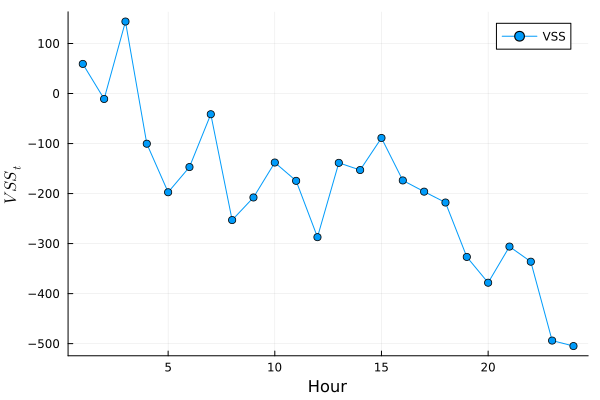

In [9]:
plot(
    1:24,
    VSS,
    label = "VSS",
    xlabel = "Hour",
    ylabel = L"VSS_t",
    marker = :circle,
)

### 6. For each N, provide spaghetti plots and ribbon plots for the energy content of the BESS. Plot the value function of state 𝜔 = 3 at stage 𝑡 = 22. See here for a description of these plots.

In [ ]:
for N in support_sizes
    println("=== Support size: $N ===")

    # Load corresponding files
    states = vec(read_file(DATA_DIR * "markov_support_$(N).txt"))
    P_prob = read_file(DATA_DIR * "markov_weights_$(N).txt")

    # Train model
    model = model_sddp(prices, states, P_prob)
    SDDP.train(model, iteration_limit = 100)

    # Simulate 10 trajectories
    simulations = SDDP.simulate(model, 10, [:b])
    plt = SDDP.SpaghettiPlot(simulations)
    SDDP.add_spaghetti(plt; title = "Battery Capacity (MWh) for $N states", xlabel="Hour", ylabel="Capacity") do data
        return data[:b].in   #Jsp s'il vaut mieux mettre in ou out, à discuter
    end
    SDDP.plot(plt, "data/spaghetti_plot_$N.html", open=false)
    plt_ribbon=Plots.plot(
    SDDP.publication_plot(simulations; title = "Battery capacity [MW]") do data
        return data[:b].in
    end
    )
    Plots.savefig(plt_ribbon,"data/ribbon_$N.pdf")
    display("text/html", read("spaghetti_plot_$(N).html", String))
end